In [1]:
import sys
sys.path.append('..')

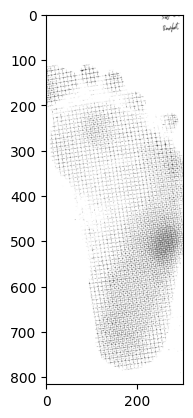

In [2]:
import numpy as np
from probreg import cpd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy.interpolate import RegularGridInterpolator

def wrap_footprint(
        img_path: str,
        filter_thread: int = 200,
        scale_factor: float = 1.3,
        l_mask_path: str = '../data/processed/left_foot_mask.png',
        l_contact_path: str = '../data/processed/points_l_contact.npy',
        r_contact_path: str = '../data/processed/points_r_contact.npy',
        ):
    # load pedar mask
    
    l_img = Image.open(l_mask_path)

    if 'L.jpg' in img_path:
        arr_pedar = np.array(l_img).astype(np.float64)

    elif 'R.jpg' in img_path:
        r_img = ImageOps.mirror(l_img)
        arr_pedar = np.array(r_img).astype(np.float64)

    else:
        raise ValueError('Image path should contain "L.jpg" or "R.jpg"')

    # load points of pedar's common contact area
    # and randomly select 1000 points
    if 'L.jpg' in img_path:
        points_pedar_full = np.load(l_contact_path)

    elif 'R.jpg' in img_path:
        points_pedar_full = np.load(r_contact_path)

    else:
        raise ValueError('Image path should contain "L.jpg" or "R.jpg"')
    
    index = np.random.randint(len(points_pedar_full), size=(1000,))
    points_pedar = points_pedar_full[index]
    pedar_bound = points_pedar.max()
    points_pedar = points_pedar / pedar_bound
    len(points_pedar), pedar_bound, points_pedar

    # load footprint and randomly select 1000 points
    img = Image.open(img_path)
    arr_img = np.array(img).astype(np.float64)
    filter_map = (np.mean(arr_img, axis=-1) < filter_thread) * 1.0
    points_footprint_full = np.stack(np.where(filter_map > 0)).T

    index = np.random.randint(len(points_footprint_full), size=(1000,))
    points_footprint = points_footprint_full[index]
    footprint_bound = points_footprint.max()
    points_footprint = points_footprint / footprint_bound

    # register pedar points to footprint points
    tf, _, _ = cpd.registration_cpd(points_pedar, points_footprint, 'rigid')

    # set shrink center as the center of pedar sensors' boundary
    points_pedar_boundary = np.array(np.where(arr_pedar[:-1, : -1] - arr_pedar[1:, 1:] != 0)).T
    shrink_center = (tf.transform(points_pedar_boundary / pedar_bound) * footprint_bound).mean(axis=0)

    # transform pedar image grid points to footprint points
    pedar_px = np.array(np.where(arr_pedar > -1)).T
    points_trans = tf.transform(pedar_px / pedar_bound) * footprint_bound
    points_trans = scale_factor * (points_trans - shrink_center) + shrink_center

    # interpolate footprint image and resample
    x_img = np.arange(arr_img.shape[0])
    y_img = np.arange(arr_img.shape[1])
    footprint_interp = RegularGridInterpolator(
        points = (x_img, y_img),
        values = arr_img.mean(axis=-1),
        bounds_error=False,
        fill_value=255,
        )
    
    arr_resample = footprint_interp(points_trans).reshape(arr_pedar.shape)
    return arr_resample

arr_warp = wrap_footprint('/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/footprint/S1-R.jpg')
plt.imshow(arr_warp, cmap='gray')
plt.show()

## Batch processing

In [5]:
import matplotlib.image
from pathlib import Path
from tqdm.auto import tqdm

img_folder = Path('/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/footprint')
export_folder = Path('../data/processed/footprint-wrap')
img_path_ls = list(img_folder.glob('*.jpg'))

for img_path in tqdm(img_path_ls):
    arr_warp = wrap_footprint(str(img_path))
    matplotlib.image.imsave(
        export_folder / f'{img_path.stem}.jpg',
        arr_warp, cmap='gray')

  0%|          | 0/104 [00:00<?, ?it/s]